In [1]:
from plot_utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch_utils import train_module

from IPython.display import display
%matplotlib inline

# Optimització - Linear regression

A estadística, la **regressió lineal** és un mètode per modelar la relació entre una resposta escalar (o variable dependent) i una o més variables explicatives (o variables independents).

A regressió lineal, les relacions es modelen mitjançant funcions lineals on els paràmetres del model s’estimen a partir de les dades. 

Aquests models s'anomenen models lineals. 

Suposem que treballem amb un conjunt de dades $ \{y_{i}, x_{i_1}, \ldots, x_{i_m} \}_{i = 1}^{n}$ de $n$ unitats. 

Un **model de regressió lineal** assumeix que la relació entre la variable dependent $y$ i el vector $p$ dels regressors $x$ és lineal. 
Així, el model pren la forma:
$${\displaystyle y_{i}=\beta _{0}+\beta _{1}x_{i_1}+\cdots +\beta _{p}x_{i_p},\qquad i=1,\ldots ,n,}$$

No es permet l'ús de cap llibreria o funció que no estigui ja importat, sigui aquí o més abaix en el notebook.

Cas simple: **Donat un conjunt de punts (X, Y) 2D, podem trobar la recta que minimitza la distància entre aquesta i tots els punts?**

Recordatori: 

Per tal de definir una recta necesitem dos punts $(x_0, y_0)$ i $(x_1, y_1)$. A partir d'aquests dos punts podem definir la recta com:

$$y={\frac {y_{1}-y_{0}}{x_{1}-x_{0}}} (x-x_{0}) +y_{0} = m \cdot x + n$$

In [2]:
def plot_fire(df, *fs, errors=False, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    plt.scatter(df['X'], df['Y'], c='C0')
    plt.xlabel('Fires per 1000 housing units')
    plt.ylabel('Thefts per 1000 population')
    plt.title('Fire and Theft in Chicago')
    
    # Asseguremnos que cada f passada a fs és una funció
    assert all(callable(f) for f in fs)
    
    x = torch.Tensor(df.X.values)
    idx = torch.argsort(x)
    x = x[idx]
    y = torch.Tensor(df.Y.values)[idx]
    
    for f in fs:
        # Calculem les prediccions
        with torch.no_grad():
            pred = f(x.unsqueeze(1))
        
        # Pintem la recta
        plt.plot(x, pred, c='black')
        
        if errors:
            # Visualització de l'error per cada punt
            for xi, yi, predi in zip(x, y, pred):
                plt.plot((xi, xi), (yi, predi), color='red', alpha=0.5)
        
def line(x, y):
    m = (y[1] - y[0]) / (x[1] - x[0])
    n = y[0] - m * x[0]
    
    def f(x):
        return (m * x + n).flatten()
    
    f.m = m
    f.n = n
        
    return f

,X,Y
0,6.2,29
1,9.5,44
2,10.5,36
3,7.7,37
4,8.6,53


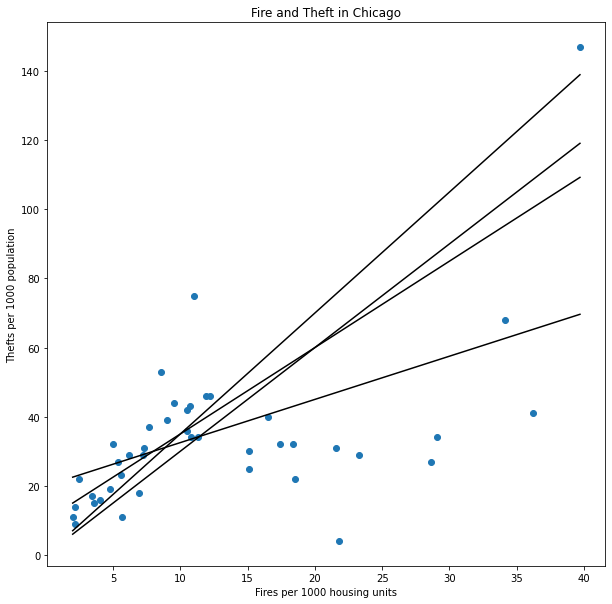

In [3]:
# Lectura de les dades
df = pd.read_csv('data/slr05.csv', index_col=0)
display(df.head())

plot_fire(
    df, 
    line([0, 40], [0, 140]),
    line([0, 40], [0, 120]),
    line([0, 40], [10, 110]),
    line([0, 40], [20, 70]),
    figsize=(10, 10)
)

Per ara, donat que estem a 2D, podem visualitzar l'error, és a dir la distància respecte aquesta recta. Però tot i així és impossible que poguem visualitzar, d'entre les infinites línies possibles, la que s'ajusta millor a les dades.

**Necessitem un algorisme que la trobi automàticament,** però primer visualitzem l'error de cadascuna de les anteriors rectes:

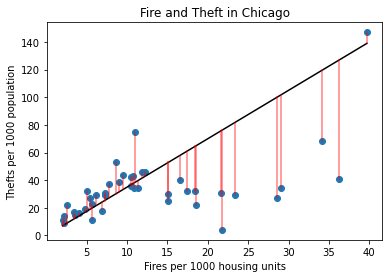

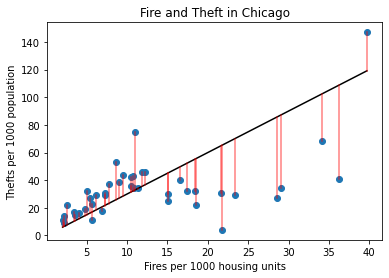

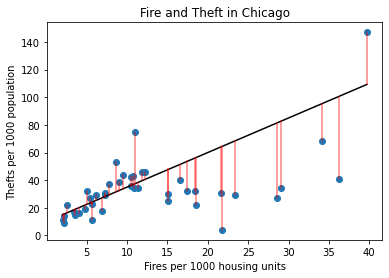

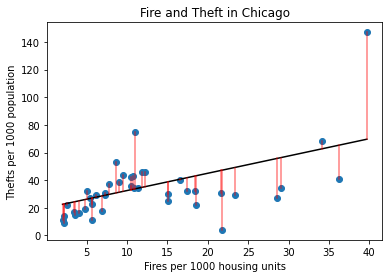

In [4]:
for f in [
    line([0, 40], [0, 140]),
    line([0, 40], [0, 120]),
    line([0, 40], [10, 110]),
    line([0, 40], [20, 70]),
]:
    plot_fire(df, f, errors=True)

**Com definim un model que automàticament trobi aquesta recta?**

Primer de tot, assumim que nosaltres tenim unes dades de les quals dispossem els valors de $x$ i els corresponents valors de $y$. Per exemple, les dades anteriors.

1. Necessitem definir matemàticament una recta
$$ r: \hat{y} = m \cdot x + n $$
On $x$ és un punt que volem evaluar, $\hat{y}$ és la imatge obtinguda en el punt $x$, i $m$, $n$ són els paràmetres que defineixen la recta. Idealment, voldríem trobar aquelles $m$, $n$ que, per tot punt $x$ tinguéssim una $\hat{y}$ tal que $\hat{y}=y$.

2. Hem de mesurar l'error que estem cometent cada cop que provem una $m$, $n$ diferents (al que anomenarem *loss* del model). Per exemple, podríem definir l'error com a la distància entre el punt $y$ que hauria de ser i el $\hat{y}$ que ens dona el model:
$$\mathbb{L} = \sqrt{(y - \hat{y})^2}$$

3. Ara el que volem fer és trobar els valors de $m$, $n$ tal que $\mathbb{L}=0$. Si parem atenció a la funció definida per $\mathbb{L}$, veurem que efectivament $0$ és el mínim d'aquesta. Per tant, tot el que hem de fer és minimitzar la funció definida per
$$\mathbb{L} = \sqrt{(y - (m \cdot x + n))^2}$$

Generem les dades que utilitzarem per entrenar el model (*X_fire*) i les seves etiquetes (*Y_fire*).

In [8]:
if __name__ == '__main__':
    X_fire = torch.Tensor(df['X'].values[:, np.newaxis])
    Y_fire = torch.Tensor(df['Y'].values)

Definirem ara un "Module", una classe que conté els paràmetres a optimitzar i la funció que prediu els valors y.

Fixeu-vos que a l'init definim dos paràmetres; això indica a la funció train_module que aquests paràmetres s'han d'optimitzar. Heu d'implementar el mètode predict que, a partir d'un X, calcula el y corresponent.

A més a més, implementarem la funció de loss que utilitzarem per optimitzar/entrenar el model.

**NOTA**: fixeu-vos que preparem el mètode per treballar amb Xs de dimensions > 1. Això serà important just a continuació.

In [9]:
from torch import nn

class LinearRegression(nn.Module):
    
    def __init__(self, dim):
        super().__init__() # necessari fer-ho abans de res
        
        self.m = nn.Parameter(torch.randn(dim))
        self.n = nn.Parameter(torch.randn(1))
        
    def predict(self, X):
       # raise NotImplementedError()
    # completeu la funció
        return torch.matmul(X, self.m) + self.n
    
def loss_f(y_true, y_pred):
    #raise NotImplementedError() 
    # completeu la funció
    return torch.linalg.norm(y_true - y_pred)

Ara crearem el model, l'entrenarem amb la funció train_module, dibuixarem les rectes amb els errors
i calcularem la loss final:

123.1033935546875

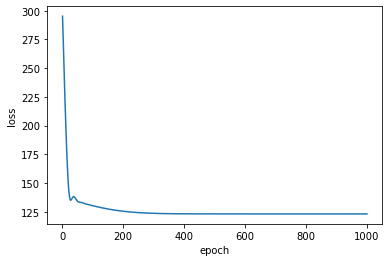

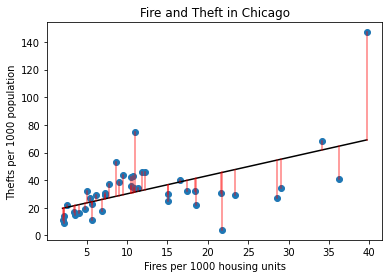

In [10]:
model = LinearRegression(X_fire.size(1))
train_module(model, X_fire, Y_fire, loss_f, n_epochs=1000, lr=1e-1)

plot_fire(df, model.predict, errors=True)
loss_f(Y_fire, model.predict(X_fire)).item()

# Linear regression amb polinomis

Imagineu que la nostra variable x ara l'elevèssim a més potències:
$x^1, x^2, x^3, ...$

La fòrmula de linear regression quedaria:

$$ r: \hat{y} = m_1 \cdot x^1 + m_2 \cdot x^2 + m_3 \cdot x^3 + ... + n $$

Fixeu-vos que llavors estem aprenent un polinomi per modelar la "recta" de predicció.

Com un polinomi de grau k inclou tots els possibles polinomis de grau k-1, els resultats només poden millorar. Provem-ho:

In [11]:
# Definim una funció per normalitzar per columnes
normalize = lambda x: (x - x.mean(0, keepdim=True)) / x.std(0, keepdim=True)

1 123.1033935546875
2 118.16313171386719
3 106.72525787353516
4 81.35220336914062
5 74.9112548828125


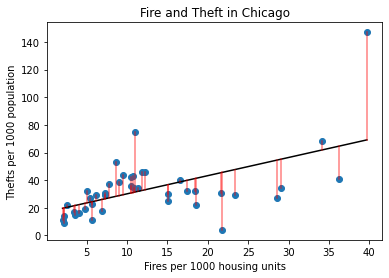

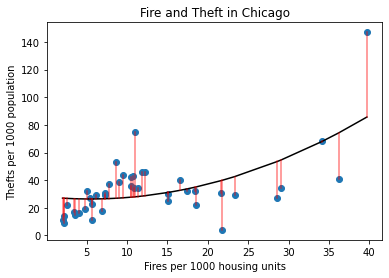

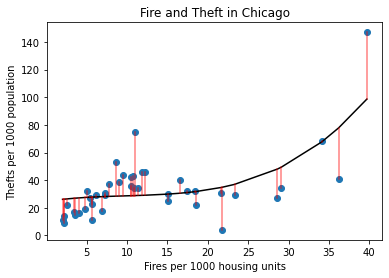

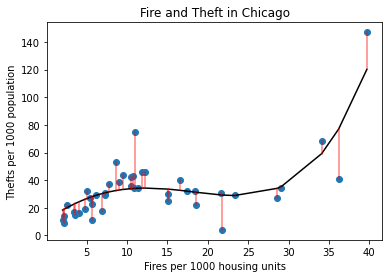

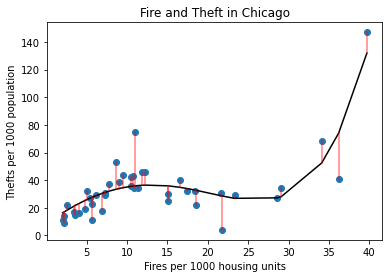

In [12]:
for i in range(1, 5 + 1):
    def preprocess(x):
        # Calcularem totes les potències fins a i, i les ajuntarem totes en la dimensió 1
        x = torch.cat([
            x ** j
            for j in range(1, i + 1)
        ], dim=1)
        
        # Normalitzeu les dades! Sense no entrenarem bé (proveu-ho).
        x = normalize(x)
        
        return x
    
    model = LinearRegression(preprocess(X_fire).size(1))
    train_module(model, preprocess(X_fire), Y_fire, loss_f, n_epochs=1000, lr=1e-1, plot=False)
    
    f = lambda x: model.predict(preprocess(x))

    plot_fire(df, f, errors=True)
    print(i, loss_f(Y_fire, f(X_fire)).item())

Hem transformat un mètode simplement lineal en un polinomi, només afegint noves columnes amb transformacions de les dades.

D'això se'n diu fer **feature engineering**: fem modificacions "intel·ligents" sobre les columnes del dataset per permetre'ns obtenir models més potents. 

Aquí ens hem limitat a fer potències de x, però podriem fer exponencials, logaritmes, talls binaris (x > 25 -> 1, x <= 25 -> 0), etc.

Ara, torneu a implementar el mètode preprocess, fent que la matriu resultant tingui:

* x (sense cap modificació)
* $e^x$
* $\log x$ (això ho podem fer perquè en aquest dataset, x > 0 sempre)
* $x > \overline{x}$, on $\overline{x}$ és la mitja de x.

**No us oblideu de normalitzar!**

Fixeu-vos com milloren els resultats:

65.5326919555664


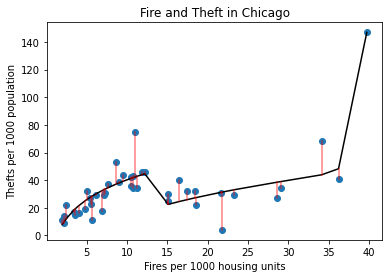

In [10]:
def preprocess(x):
    raise NotImplementedError() # completeu la funció

model = LinearRegression(preprocess(X_fire).size(1))
train_module(model, preprocess(X_fire), Y_fire, loss_f, n_epochs=1000, lr=1e-1, plot=False)

f = lambda x: model.predict(preprocess(x))

plot_fire(df, f, errors=True)
print(loss_f(Y_fire, f(X_fire)).item())

# Dades multidimensionals

En l'apartat anterior hem passat de tenir un sol valor x a tenir-n'hi múltiples, modificant x de diverses maneres.

Ara treballarem amb un dataset on les dades d'entrada són majors (6 dimensions).

In [11]:
if __name__ == '__main__':
    # Lectura de les dades
    dg = pd.read_csv('data/mlr10.csv', index_col=0)
    Y_pop = torch.Tensor(dg.values[:, 0])
    X_pop = torch.Tensor(dg.values[:, 1:])
    display(dg.head())

,Total population (in thousands),% Change in population,% Change in children,% Free school lunch,% change in household income,Crime rate,% change in crime rate
0,6.9,1.8,30.2,58.3,27.3,84.9,-14.2
1,8.4,28.5,38.8,87.5,39.8,172.6,-34.1
2,5.7,7.8,31.7,83.5,26.0,154.2,-15.8
3,7.4,2.3,24.2,14.2,29.4,35.2,-13.9
4,8.5,-0.7,28.1,46.7,26.6,69.2,-13.9


En aquest cas no podem pintar la nostra recta, ja que té més de 2 dimensions. Però podem calcular la loss i veure com millora a mesura que canviem el model.

In [12]:
for i in range(1, 5 + 1):
    def preprocess(x):
        # Calcularem totes les potències fins a i, i les ajuntarem totes en la dimensió 1
        x = torch.cat([
            x ** j
            for j in range(1, i + 1)
        ], dim=1)
        
        # Normalitzeu les dades! Sense no entrenarem bé (proveu-ho).
        x = normalize(x)
        
        return x
    
    model = LinearRegression(preprocess(X_pop).size(1))
    train_module(model, preprocess(X_pop), Y_pop, loss_f, n_epochs=10000, lr=1e-3, plot=False)

    f = lambda x: model.predict(preprocess(x))

    print(i, loss_f(Y_pop, f(X_pop)).item())

1 20.528173446655273
2 17.880346298217773
3 17.496078491210938
4 16.87870979309082
5 16.312673568725586


Feu feature engineering vosaltres mateixos i intenteu aconseguir que la vostra loss sigui **inferior a 0.1**.

Podeu canviar els valors d'entrenament (canviar el nombre d'epochs, o el learning rate lr), <br />
tot i que els valors establerts (```n_epochs=10000, lr=1e-3```) ja us poden donar el resultat esperat.

Idees:

* Feu servir les potències de cada columna de x.
* Penseu si ajuda o no normalitzar abans de fer cap modificació.
* Proveu a afegir algunes funcions diferents (log, exp, binarització...).
* Combinacions.

**Combinacions**:

Tenim 6 columnes d'input. Les tres primeres millores utilitzen transformacions que només aprofiten cada columna per separat ($X_1^3$, $X_2^3$, etc.)

Però què passa si "barregem" columnes, fent que el model pugui aprofitar les interaccions entre elles?

Per exemple, podriem afegir les columnes $X_1 \cdot X_2, X_1 \cdot X_3, ..., X_5 \cdot X_6$.

Això serien les combinacions de 2 elements. I de 6 elements?

$X_1 \cdot X_2 \cdot X_3 \cdot X_4 \cdot X_5 \cdot X_6$.

Veieu si ajuda, i com, aquest afegit.

0.08341491967439651


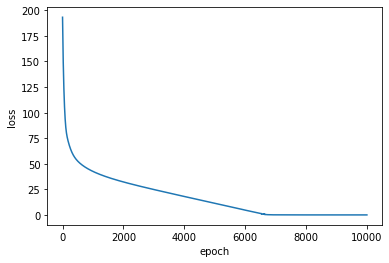

In [13]:
torch.random.manual_seed(123) # deixeu aquesta linia, garantirà que els resultats siguin consistents 

def preprocess(x):    
    raise NotImplementedError() # completeu la funció

model = LinearRegression(preprocess(X_pop).size(1))
train_module(model, preprocess(X_pop), Y_pop, loss_f, n_epochs=10000, lr=1e-3, plot=True)

f = lambda x: model.predict(preprocess(x))

print(loss_f(Y_pop, f(X_pop)).item())

**Nota**:

Tot i que veiem que podem millorar el resultat del model tant com vulguem a base d'afegir més i més columnes, hi ha el perill que el vostre model retorni una loss molt i molt baixa, però en realitat el model no sigui bo. D'això en diem **overfitting**.

No ho tindrem en compte en aquesta pràctica, però a la següent veurem com afecta aquest fenòmen.